# 0.参数设定

In [16]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.10'

In [50]:
import pickle, re, os, time
import jax, optax, jax.random as rd, jax.numpy as jnp, flax.linen as nn, numpy as np, matplotlib.pyplot as plt
from functools import partial
from DataLoader import DataLoader,take_data,Generation_DataSet
from optical_flax.fiber_system import get_data, Tx_data
from optical_flax.fiber_tx import  wdm_base
from optical_flax.layers import MetaSSFM, GRU_DBP, fdbp, NNSSFM,Dense_net
from optical_flax.models import Transformer, CNN, xi_config,H_config
from optical_flax.initializers import fdbp_init, near_zeros,ones
from optical_flax.utils import realize,show_tree
from commplax.module.core import Signal
from commplax import xop
import argparse
import scipy.constants as const
from jax.numpy.fft import fft,ifft,fftfreq,fftshift

from jax.config import config
config.update("jax_enable_x64", True)


path = '/home/xiaoxinyu/data/0712train_36G/dataset_sps8/data_ch3_power0_FO0_lw0'
data_sml = get_data(path,sps=2)

C = const.c                         # speed of light [m/s]
D = data_sml.a['D']                     # [s/m^2]
fc = data_sml.a['carrier_frequency']    # [Hz]
alphaB = data_sml.a['fiber_loss']       # [dB/m]
gamma = data_sml.a['gamma']             # [/W/m]
alpha = alphaB / 10 * np.log(10.)       # [/m]
lamb = C/fc                             # [m]
beta2 = -(D*lamb**2)/(2*np.pi*C)        # [s^2/m]


setting = 'Toy'

if setting == 'Huawei':
    ## Hua Wei setting
    Nmodes=2
    span_length = 80e3                      # [m]
    span_number = 25                        # [1]
    Nch = 19                                # [1]
    power = 3                               # [dBm]
    Rs = 190e9                              # [Hz]
    freqspace = 220e9                       # [Hz]
    sps = 32                                # tx sps
    sps_single = 2                          # cssfm single channel sps
    pulse_taps = 4096
    Fs = Rs * sps
    Nsymb = 10000
    Nfft = Nsymb*sps
    omega = 2*np.pi*Fs*fftfreq(Nfft)

elif setting == 'Toy':
    ## Toy setting
    Nmodes=1
    span_length = 100e3                     # [m]
    span_number = 1                         # [1]
    Nch = 3                                 # [1]
    power = 10                              # [dBm]
    Rs = 10e9                               # [Hz]
    freqspace = 50e9                        # [Hz]
    sps = 16                                # tx sps
    sps_single = 2                          # cssfm single channel sps
    Fs = Rs * sps
    Nsymb = 256
    pulse_taps = 4096
    Nfft = Nsymb*sps
    omega = 2*np.pi*Fs*fftfreq(Nfft)

Tx = partial(Tx_data, Nch=Nch, Power=power, SpS=sps, Nbits=4*Nsymb, Rs=Rs, freq_space=freqspace, Nmodes=Nmodes, pulse_taps=pulse_taps)
sigWDM, symbWDM, param = Tx(rd.PRNGKey(123), 1)
freqGrid = param.freqGrid
x = sigWDM[:,0]
print('mean signal power: %g [W]' % jnp.mean(jnp.abs(x)**2))

beta1 = 2*np.pi*freqGrid*beta2   # (Nch,)
Fs_single = Rs * sps_single     
Nfft_single = Nsymb * sps_single
omega_single = 2*np.pi * Fs_single * fftfreq(Nfft_single)

Sample rate fa: 1.6e+11, Cut off frequency fc: 7.5e+10, fa > 2fc: True
Transmitter is working..
signal shape: (4096, 1), symb shape: (256, 3, 1)
 Tx_data complete, time cost(s):1.4001538753509521
mean signal power: 0.03 [W]


In [64]:
def exp_integral(z):
    '''
       P(z) = exp( -alpha *(z % Lspan))
       exp_integral(z) = int_{0}^{z} P(z) dz
    '''
    k = z // span_length
    z0 = z % span_length

    return k * (1 - jnp.exp(-alpha * span_length)) / alpha + (1- jnp.exp(-alpha * z0)) / alpha


def Leff1(z, dz):
    ''' 
    split form 1: no normalization
    '''
    return dz

def Leff2(z, dz):
    '''
    split form 1: normalization
    '''
    return exp_integral(z + dz) - exp_integral(z)



def H1(dz):
    ''' 
    split form 1: no normalization
    '''
    return jnp.exp(-alpha/2*dz - 1j * (beta2/2) * (omega**2) * dz)


def H2(dz):
    '''
    split form 1: normalization
    '''
    # omega = get_omega(Fs, Nfft)
    return jnp.exp(-1j * (beta2/2) * (omega**2) * dz)



def L2(x):
    return jnp.sqrt(jnp.mean(jnp.abs(x)**2))

def relative_L2(x,y):
    return L2(x-y) / L2(x)

def MSE(x,y):
    return jnp.mean(jnp.abs(x-y)**2)

def test_convergence(E, method, dz,length=80e3):
    Eo = []
    loss = []
    for h in dz:
        Eo.append(method(E, length,h))
    
    for i in range(len(dz)-1):
        loss.append(relative_L2(Eo[i], Eo[i+1]).item())

    return Eo,loss

def rx(E, k, new_sps):
    t = jnp.linspace(0,1/Fs*Nfft, Nfft)
    f = omega/(2*np.pi)
    x0 = ifft(jnp.roll(fft(E, axis=0) * (jnp.abs(f - k*freqspace)<freqspace/2), -k*int(freqspace/Fs*Nfft), axis=0), axis=0)
    rate = sps // new_sps
    return x0[::rate]

def wdm_split(E,  new_sps:int):
    '''' 
    Get every single channel information from WDM signal.
    Input:
        E: 1D array. WDM signal. (Nfft,Nmodes)
        new_sps: Output sps.
    Output:
        E: single channel signal. (Nfft, Nch, Nmodes)
    '''

    signal = []
    M = Nch//2 
    E0 = jax.vmap(rx, in_axes=(None, 0, None), out_axes=0)(E, jnp.arange(-M, M+1), new_sps)
    return E0

Sample rate fa: 1.6e+11, Cut off frequency fc: 7.5e+10, fa > 2fc: True
Transmitter is working..
signal shape: (4096, 1), symb shape: (256, 3, 1)
 Tx_data complete, time cost(s):2.148212432861328
Sample rate fa: 1.6e+11, Cut off frequency fc: 7.5e+10, fa > 2fc: True
Transmitter is working..
signal shape: (4096, 3, 1), symb shape: (256, 3, 1)
 Tx_data complete, time cost(s):1.0792019367218018


/home/xiaoxinyu/.conda/envs/commplax/lib/python3.8/site-packages/jax/_src/device_array.py:264: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._value, dtype=dtype)
/home/xiaoxinyu/.conda/envs/commplax/lib/python3.8/site-packages/jax/_src/device_array.py:264: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._value, dtype=dtype)


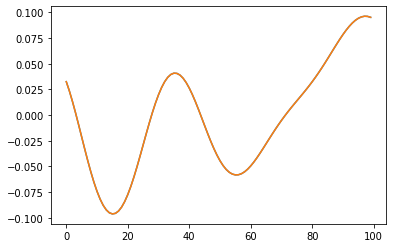

In [61]:
sigWDM, symbWDM, param = Tx(rd.PRNGKey(123), 1)
x = sigWDM[:,0]
x_,_,_ = Tx(rd.PRNGKey(123), 1, equation='CNLSE')
plt.plot(wdm_split(x, sps)[1,0:100])
plt.plot(x_[0:100,1,0])

# 1.SSFM

In [28]:
@partial(jax.jit, static_argnums=(3))
def L(E, z:float, dz:float, H=H1): 
    return ifft(fft(E, axis=0) * H(dz), axis=0)


@partial(jax.jit, static_argnums=(3))
def NL(E, z:float, dz:float, Leff=Leff1):
    phi = gamma * Leff(z, dz) * jnp.abs(E)**2
    x = jnp.exp(-(1j)*phi)*E
    return x


def ssfm1(E, length, dz, H=H1, Leff=Leff1):
    K = int(length / dz)
    z = 0 
    for i in range(K):
        E = L(E, z, dz, H)
        E = NL(E, z, dz, Leff)
        z = z + dz
    return E

def ssfm2(E, length, dz, H=H1, Leff=Leff1):
    K = int(length / dz)
    z = 0
    for i in range(K):
        E = L(E, z, dz/2, H)
        E = NL(E,z, dz, Leff)
        E = L(E, z, dz/2, H)
        z = z + dz
    return E

def amp1(E, span_length):
    '''
    Ideal EDFA
    '''
    x = jnp.exp(1/2*alpha*span_length)*E
    return x

def amp2(E, span_length):
    '''
    identity
    '''
    return E

def fiber(E, dz, spans=20, span_length = 80e3, module=ssfm1, amp=amp2):
    for i in range(spans):
        E = module(E, span_length, dz)
        E = amp(E, span_length)
    return E


# 2.WDM-SSFM

In [30]:
def CH1(dz):
    ''' 
    No normalization
    '''
    return jnp.exp(-alpha/2*dz - 1j*beta1[:,None]*omega_single[None,:]*dz - 1j*beta2/2*omega_single**2*dz)

def CLeff1(z,dz):
    ''' 
    No normalization
    '''
    return dz

def CH2(dz):
    ''' 
    normalization
    '''
    return jnp.exp(- 1j*beta1[:,None]*omega_single[None,:]*dz - 1j*beta2/2*omega_single**2*dz)

def CLeff2(z,dz):
    ''' 
    normalization
    '''
    return exp_integral(z + dz) - exp_integral(z)

@partial(jax.jit, static_argnums=(3))
def CL(E,z,dz,H=CH1):
    '''
        E: [Nch, Nfft]
        H(dz): [Nch, Nfft]
    '''
    return ifft(fft(E, axis=1) * H(dz), axis=1)

@partial(jax.jit, static_argnums=(3))
def CNL(E,z,dz,Leff=CLeff1):
    power = E * jnp.conj(E)
    P = jnp.sum(power, axis=0)
    phi = gamma * Leff(z, dz) * (2*P[None,:] - power)
    return jnp.exp(-(1j)*phi)*E

def cssfm1(E, length, dz, H=CH1, Leff=CLeff1):
    K = int(length / dz)
    z = 0 
    for i in range(K):
        E = CL(E, z, dz, H)
        E = CNL(E, z, dz, Leff)
        z = z+ dz
    return E

def cssfm2(E, length, dz, H=CH1, Leff=CLeff1):
    K = int(length / dz)
    z = 0 
    for i in range(K):
        E = CL(E, z, dz/2, H)
        E = CNL(E, z, dz, Leff)
        E = CL(E, z, dz/2, H)
        z = z+ dz
    return E

# 3.Manakov

In [47]:
def MH(dz):
    return jnp.exp(-alpha/2*dz - 1j*beta2/2*omega**2*dz)

def MLeff(z,dz):
    return dz

@partial(jax.jit, static_argnums=(3))
def ML(E, z, dz, H=MH):
    ''' 
    E: [Nfft, Nmodes]
    '''
    return ifft(fft(E, axis=0) * H(dz)[:,None], axis=0)

@partial(jax.jit, static_argnums=(3))
def MNL(E,z,dz,Leff=MLeff):
    phi = 8 / 9 * gamma * Leff(z, dz) * jnp.sum(jnp.abs(E)**2, axis=1)[:,None]
    return jnp.exp(-(1j)*phi)*E

def manakov1(E, length, dz, H=MH, Leff=MLeff):
    # E [Nfft, Nmodes]
    K = int(length / dz)
    z = 0
    for i in range(K):
        E = ML(E, z, dz, H)
        E = MNL(E, z, dz, Leff)
        z = z+ dz
    return E

def manakov2(E, length, dz, H=MH, Leff=MLeff):
    K = int(length / dz)
    z = 0
    for i in range(K):
        E = ML(E, z, dz/2, H)
        E = MNL(E, z, dz, Leff)
        E = ML(E, z, dz/2, H)
        z = z+ dz
    return E

# 4.WDM-Manakov

In [48]:
beta1 = 2*np.pi*freqGrid*beta2
Fs_single = Rs * sps_single
Nfft_single = Nsymb * sps_single
omega_single = 2*np.pi * Fs_single * fftfreq(Nfft_single)

def CMH1(dz):
    ''' 
    No normalization

    return: [Nch, Nfft, 1]
    '''
    return jnp.exp(-alpha/2*dz - 1j*beta1[:,None]*omega_single[None,:]*dz - 1j*beta2/2*omega_single**2*dz)[...,None]

def CMLeff1(z,dz):
    ''' 
    No normalization
    '''
    return dz

def CMH2(dz):
    ''' 
    normalization

    return: [Nch, Nfft, 1]
    '''
    return jnp.exp(- 1j*beta1[:,None]*omega_single[None,:]*dz - 1j*beta2/2*omega_single**2*dz)[...,None]

def CMLeff2(z,dz):
    ''' 
    normalization
    '''
    return exp_integral(z + dz) - exp_integral(z)

@partial(jax.jit, static_argnums=(3))
def CML(E,z,dz,H=CMH1):
    '''
        E: [Nch, Nfft, Nmodes]
        H(dz): [Nch, Nfft, 1]
    '''
    return ifft(fft(E, axis=1) * H(dz), axis=1)

@partial(jax.jit, static_argnums=(3))
def CMNL(E,z,dz,Leff=CMLeff1):
    power = E * jnp.conj(E)
    P = jnp.sum(power, axis=0)   # [Nfft, Nmodes]
    Ps = jnp.sum(P, -1)          # [Nfft]
    phi = gamma * Leff(z, dz) * (P[None,:] + Ps[None,:,None] - power)
    return jnp.exp(-(1j)*phi)*E

def cmanakov1(E, length, dz, H=CMH1, Leff=CMLeff1):
    K = int(length / dz)
    z = 0 
    for i in range(K):
        E = CL(E, z, dz, H)
        E = CNL(E, z, dz, Leff)
        z = z+ dz
    return E

def cmanakov2(E, length, dz, H=CMH1, Leff=CMLeff1):
    K = int(length / dz)
    z = 0 
    for i in range(K):
        E = CL(E, z, dz/2, H)
        E = CNL(E, z, dz, Leff)
        E = CL(E, z, dz/2, H)
        z = z+ dz
    return E

# 5.Pertubation

In [49]:
linear = partial(L,z=0,H=H2)
nonlinear = partial(NL, Leff=Leff2)
linear_vmap = jax.vmap(linear)
linear_vmap0 = jax.vmap(linear,in_axes=(None))

def circ_conv(x,y):
    '''
    使用fft实现周期卷积
    '''
    return ifft(fft(x)*fft(y))

def full_conv(x,y):
    ''' 
    使用周期卷积实现全卷积
    '''
    L = len(x) + len(y) - 1
    x_pad = jnp.concatenate([x,np.zeros(L-len(x))])
    y_pad = jnp.concatenate([y,np.zeros(L-len(y))])
    return circ_conv(x_pad,y_pad)

def circ_conv2(x,y):
    '''
    使用全卷积实现周期卷积
    '''
    N = x.shape[0]
    return jnp.convolve(x,y)[0:N] + jnp.concatenate([jnp.convolve(x,y)[N:2*N-1],jnp.zeros(1)])




@partial(jax.jit,static_argnums=(3))
def RP(v, v0, span_length, integral_points):
    ''' 
    RP iteration
    '''
    xi = jnp.linspace(0,span_length, integral_points)
    temp = jnp.exp(-alpha*xi)[:,None] * jnp.abs(v)**2 * v
    temp_hat = fft(temp, axis=1)  # [z_sample, Nfft]
    H = jax.vmap(H2)(xi)          # [z_sample, Nfft]
    out = jax.vmap(full_conv, in_axes=1, out_axes=1)(temp_hat, H) 
    boundary = 0.5*(temp_hat[0:1,:] * H + H[0:1,:] * temp_hat)
    out = (out[0:integral_points,:] - boundary) * xi[1]
    out = ifft(out, axis=1)
    return  v0 - (1j)*gamma* out

def RP_solver(E, length, n, integral_points=100):
    xi = jnp.linspace(0,length, integral_points)
    v0 = linear_vmap0(E, dz=xi)
    v = v0

    v_list = []
    v_list.append(v0)
    for i in range(n):
        v = RP(v, v0, length, integral_points)
        v_list.append(v)
    return v_list


#@partial(jax.jit,static_argnums=(3))
def LP(v, v0, span_length, integral_points):
    ''' 
    RP iteration
    '''
    xi = jnp.linspace(0,span_length, integral_points)
    temp = jnp.exp(-alpha*xi)[:,None] * jnp.abs(v)**2 * v
    temp_hat = fft(temp, axis=1)  # [z_sample, Nfft]
    H = jax.vmap(H2)(xi)          # [z_sample, Nfft]
    out = jax.vmap(full_conv, in_axes=1, out_axes=1)(temp_hat, H) 
    boundary = 0.5*(temp_hat[0:1,:] * H + H[0:1,:] * temp_hat)
    out = (out[0:integral_points,:] - boundary) * xi[1]
    out = ifft(out, axis=1)
    return  v*jnp.exp(-(1j)*gamma*out/v0 - (v-v0)/v0)

def LP_solver(E, length, n, integral_points=100):
    xi = jnp.linspace(0,length, integral_points)
    v0 = linear_vmap0(E, dz=xi)
    v = v0

    v_list = []
    v_list.append(v0)
    for i in range(n):
        v = LP(v, v0, length, integral_points)
        v_list.append(v)
    return v_list


def CutRP(E, length, n, integral_points=100):
    xi = jnp.linspace(0,length, integral_points)

    def fn(temp):
        temp_hat = fft(temp, axis=1)  # [z_sample, Nfft]
        H = jax.vmap(H2)(xi)          # [z_sample, Nfft]
        out = jax.vmap(full_conv, in_axes=1, out_axes=1)(temp_hat, H) 
        out = out[0:integral_points,:] * xi[1]
        out = ifft(out, axis=1)
        return out
    u = []
    u.append(linear_vmap0(E, dz=xi))

    for n_ in range(1,n+1):
        temp = 0
        for k in range(n_):
            for i in range(k+1):
                temp = temp + u[i]*u[k-i]*u[n_ - 1 - k].conj()
        temp = jnp.exp(-alpha*xi)[:,None] * temp
        u.append(-1j*fn(temp))

    v = []
    v.append(u[0])
    for i in range(1,n + 1):
        v.append(v[-1]+gamma**i*u[i]) 
        
    return u, v


def save_divide(u,u0,n, cutoff=0.5):
    # temp = u/u0*gamma**n
    # temp = jnp.minimum(temp.real,cutoff) + temp.imag*(1j)
    # return temp / gamma**n
    return u/u0

def CutLP(E,length, n, integral_points):
    u,v = CutRP(E,length, n, integral_points)
    p1 = save_divide(u[1], u[0], 1)
    p2 = save_divide(u[2], u[0], 2) - 1/2*p1**2
    p3 = save_divide(u[3], u[0], 3) - p1*p2 - 1/6*p1**3
    p4 = save_divide(u[4], u[0], 4) - p1*p3 - 1/2*p2**2 - 1/2*p1**2*p2 - 1/24*p1**4
    
    psi = [p1,p2,p3,p4]
    v = []
    v.append(u[0])
    for i in range(1,n+1):
        v.append(v[-1]*jnp.exp(gamma**i*psi[i-1])) 
    return psi,v

# 6.DBP

## 6.1 CDC, FDBP, SDBP

In [50]:
def show_symb(sig,symb,s=10):
    symb_set = set(symb)
    for sym in symb_set:
        z = sig[symb == sym]
        plt.scatter(z.real, z.imag, s=s)


def DBP_H2(dz, Nfft):
    '''
    DBP split form 1: normalization
    kernel: frequency domain
    '''
    omega = 2*np.pi * Fs_single * fftfreq(Nfft)
    return jnp.exp(-1j * (beta2/2) * (omega**2) * dz)

def DBP_h2(dz, dtaps):
    '''
    DBP split form 1: normalization
    kernel: time domain
    '''
    return fftshift(ifft(DBP_H2(dz, dtaps)))

H0 = partial(DBP_H2, Nfft=Nfft_single)

def FDBP(E, length, dz, H=H2, Leff=Leff2):

    K = int(length / dz)
    z = length 
    for i in range(K):
        E = L(E, z, -dz, H)
        E = NL(E, z, -dz, Leff)
        z = z - dz
    return E


def SDBP(E, length, dz, H=H0, Leff=CLeff2):
    K = int(length / dz)
    z = length 
    for i in range(K):
        E = L(E, z, -dz, H)
        E = NL(E, z, -dz, Leff)
        z = z - dz
    return E

def CDC(E, length, dz):
    return L(E, 0, -length, H0)

span_number = 1
F = partial(fiber, spans=span_number,span_length=span_length)
real_fiber = partial(F, module=partial(ssfm2, H=H2,Leff=Leff2))
fdbp_fiber = partial(F, module=FDBP)
sdbp_fiber = partial(F, module=SDBP)
cdc_fiber = partial(F, module=CDC)

chid = Nch//2
# fiber
Tx = partial(Tx_data, Nch=Nch, Power=17, SpS=sps, Nbits=4*Nsymb, Rs=Rs, freq_space=freqspace, Nmodes=Nmodes, pulse_taps=pulse_taps)
sigWDM, symbWDM, param = Tx(rd.PRNGKey(0), 1)
x = sigWDM[:,0]
symb = jax.device_get(symbWDM[:,chid,0])

y = real_fiber(x, dz=100)

# 中心通道
x0 = wdm_split(x, Nch, sps_single)[chid]   # truth
y0 = wdm_split(y, Nch, sps_single)[chid]   # input

# CDC compare
x_cdc1 = L(y0, 0, -span_length, H0)
h = DBP_h2(-span_length,101)
x_cdc2 = circFilter(h,y0)

# FDBP
x_fdbp0 = fdbp_fiber(y, dz=100)
x_fdbp = wdm_split(x_fdbp0, Nch, sps_single)[chid]

# SDBP
x_sdbp = sdbp_fiber(y0, dz=100)

# CDC
x_cdc = cdc_fiber(y0,dz=span_length)

Sample rate fa: 1.6e+11, Cut off frequency fc: 7.5e+10, fa > 2fc: True
Transmitter is working..
signal shape: (160000, 1), symb shape: (10000, 3, 1)
 Tx_data complete, time cost(s):1.9307074546813965


MSE of two cdc ways:  7.885436701576993e-06


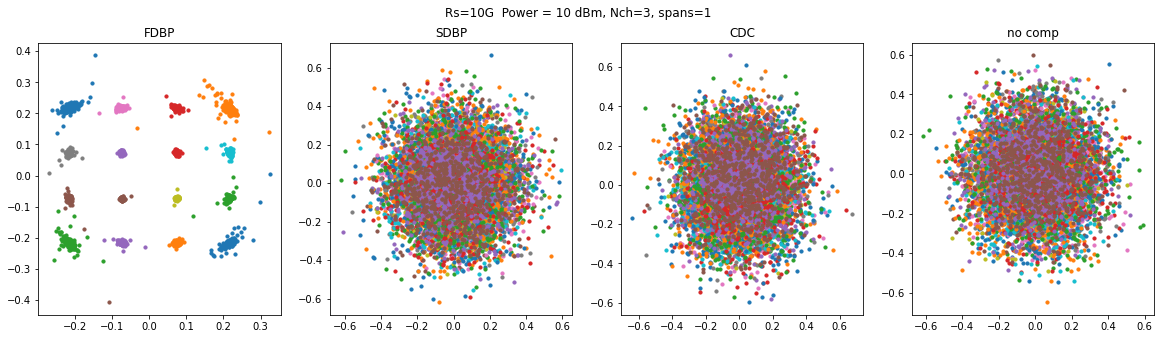

In [51]:

plt.figure(figsize=(20,5))
plt.suptitle(f'Rs={int(Rs/1e9)}G  Power = {power} dBm, Nch={Nch}, spans={span_number}')

plt.subplot(1,4,1)
z = x_fdbp[0::sps_single]
show_symb(z,symb)
plt.title('FDBP')

plt.subplot(1,4,2)
z = x_sdbp[::sps_single]
show_symb(z,symb)
plt.title('SDBP')

plt.subplot(1,4,3)
z = x_cdc[::sps_single]
show_symb(z,symb)
plt.title('CDC')

plt.subplot(1,4,4)
z = y0[::sps_single]
show_symb(z,symb)
plt.title('no comp')

print('MSE of two cdc ways: ', MSE(x_cdc1,x_cdc2)/MSE(x_cdc1,0))

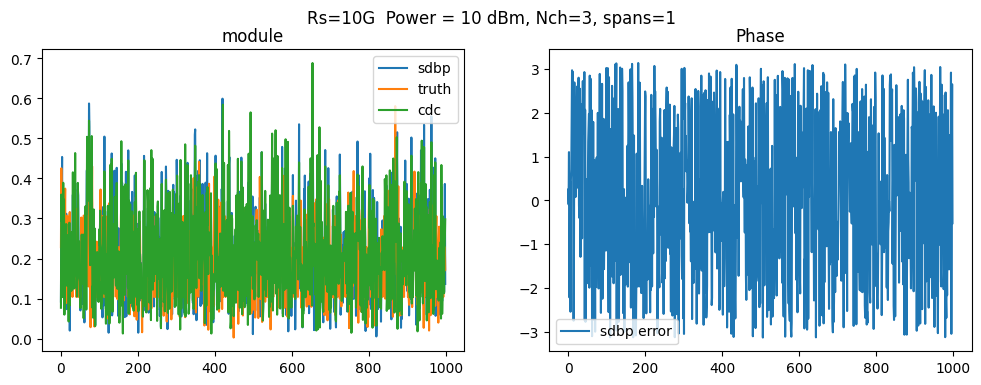

In [52]:
plt.figure(figsize=(12,4),dpi=100)
plt.suptitle(f'Rs={int(Rs/1e9)}G  Power = {power} dBm, Nch={Nch}, spans={span_number}')
s = 1000
e = 2000
plt.subplot(1,2,1)

plt.plot(jnp.abs(x_sdbp[s:e]), label='sdbp')
plt.plot(jnp.abs(x0[s:e]), label='truth')
plt.plot(jnp.abs(x_cdc1[s:e]), label='cdc')
plt.title('module')
plt.legend()

plt.subplot(1,2,2)
plt.plot(jnp.angle(x_sdbp[s:e]/x0[s:e]), label='sdbp error')
# plt.plot(jnp.angle(x_cdc[s:e]/x0[s:e]), label='cdc error')
# plt.plot(jnp.angle(x0[s:e]),label='truth')
plt.title('Phase')
plt.legend()

**结论： 信息传输速率的增加会使得XPM noise变简单 ！！！！**

## 6.2 LDBP

In [53]:
Dense  = partial(nn.Dense,dtype=jnp.complex64, param_dtype=jnp.complex64, kernel_init=near_zeros, bias_init=near_zeros)
Dense(features=2).init(rd.PRNGKey(0),jnp.ones(5))

FrozenDict({
    params: {
        kernel: DeviceArray([[-5.6301844e-03-0.00112652j,  8.6483462e-03+0.01099382j],
                     [ 1.5708733e-02-0.00899192j,  7.2972779e-03+0.00059244j],
                     [-8.6216936e-03+0.00798776j,  1.1959120e-02-0.00025119j],
                     [ 6.9247960e-04+0.0012289j , -1.5070528e-02-0.00223372j],
                     [ 4.1923602e-03-0.00486179j, -7.4475497e-06+0.00557373j]],            dtype=complex64),
        bias: DeviceArray([-0.00080341+0.00059403j, -0.01455554-0.00072619j], dtype=complex64),
    },
})

In [54]:
from typing import Any, Callable
from optical_flax.functions import cleaky_relu
from optical_flax.initializers import near_zeros, ones
class DNN(nn.Module):
    features:int = 20
    width:list = (60,60)
    dropout_rate:float = 0.5
    dtype:Any = jnp.complex64
    param_dtype:Any = jnp.complex64
    act:Callable=cleaky_relu
    result_init:Callable=near_zeros
    to_real: Any=False
    nn_mode: bool=False
    '''
        input: 
        case 0: [batch, dtaps, Nmodes] --> [batch, dtaps,Nmodes]  (encoder)
        case 2: [batch, dtaps, Nmodes] --> [batch, 1, Nmodes]  (encoder + regression)


        nn_mode: Degenerate to NNSSFM if True.
        to_real: Transform output to real number if True.
    '''

    @nn.compact
    def __call__(self, inputs, deterministic=True):
        if self.nn_mode==True:   
            p = self.param('nn_weight', self.result_init)
            p = p[None,:]
        else:
            Dense  = partial(nn.Dense,dtype=self.dtype, param_dtype=self.param_dtype, kernel_init=near_zeros, bias_init=near_zeros)
            x = nn.LayerNorm(dtype=self.dtype,param_dtype=self.param_dtype,reduction_axis=0,feature_axis=-1)(inputs)
            batch = x.shape[0]
            x = x.reshape(batch, -1)
            for w in self.width:
                x = Dense(features=w)(x)
                x = self.act(x) 
                x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=deterministic)
            # TODO: weight initializers.
            # x = Dense(features=self.features, bias_init=self.result_init)(x)
            
            # FIXME: Another choise  
            bias = self.result_init('key')
            p = Dense(features=self.features, use_bias=True)(x) + bias
        if self.to_real == True:
            p = jnp.abs(p)**2
        return jnp.stack([p]*inputs.shape[-1], axis=-1)
    

from typing import Any
def H_init(key, dz, Nfft):
    return DBP_H2(dz, Nfft)

def ones(key, Nfft):
    return jnp.ones(Nfft)
    
sps_dbp = sps
L_meta = partial(DNN,  width=(80,80,80))
NL_meta = partial(DNN, width=(80,80,80), to_real=True)

class DBP_L(nn.Module):
    z: float=100e3
    dz: float=100
    meta: Any=L_meta
    nn_mode:bool=False
    

    @nn.compact
    def __call__(self, x):
        '''
            x [batch, Nfft, Nmodes]
            H [Nfft, Nmodes]
        '''
        H = self.meta(features=x.shape[1],result_init=partial(H_init, dz=-self.dz, Nfft=x.shape[1]),nn_mode=self.nn_mode)(x)
        x = ifft(fft(x, axis=1) * H, axis=1)
        return x



class DBP_NL(nn.Module):
    z: float=100e3
    dz:float=100
    Leff: Any=Leff2
    meta: Any=NL_meta
    nn_mode: bool=False
    
    @nn.compact
    def __call__(self, x):
        '''
            x [batch, Nfft, Nmodes]

        '''
        xi = self.meta(features=x.shape[1],result_init=partial(ones, Nfft=x.shape[1]),nn_mode=self.nn_mode)(x)
        phi = gamma * self.Leff(self.z, -self.dz) * jnp.abs(x)**2 * xi
        return jnp.exp(-(1j)*phi)*x

class LDBP(nn.Module):
    length:100e3
    steps:int=10
    nn_mode:bool=False
    @nn.compact
    def __call__(self,y):
        dz = self.length / self.steps
        z = self.length
        for i in range(self.steps):
            y = DBP_L(z=z, dz=dz, nn_mode=self.nn_mode)(y)
            y = DBP_NL(z=z, dz=dz, nn_mode=self.nn_mode)(y)
            z = z - dz
        return y


## data generation

In [ ]:
from optical_flax.utils import HiddenPrints
from tqdm import tqdm
Tx = partial(Tx_data, Nch=Nch, Power=power, SpS=sps, Nbits=4*Nsymb, Rs=Rs, freq_space=freqspace, Nmodes=Nmodes, pulse_taps=pulse_taps)
def data_generation(key, batch, batch_num, dz=100, chid=Nch//2):
    keyfull = rd.split(key, batch_num)
    data = []
    batch = 100
    for k in tqdm(keyfull, desc='generate data'):
        with HiddenPrints():
            sigWDM, symbWDM, param = Tx(k,batch)   # [batch, Nfft, Nmodes], [batch, Nsymb, Nch, Nmodes]
        y = batch_wdm_split(sigWDM, Nch, sps)      # y [batch, Nch, Nfft, Nmodes]
        y = y[:,chid,:,:]                          # y [batch, Nfft, Nmodes]
        x = real_fiber(sigWDM[:,:,0], dz=dz)       # [batch, Nfft]
        x = x[...,None]                            # [batch, Nfft, Nmodes]
        symb = symbWDM[:,:,chid,:]                 # [batch, Nsymb, Nmodes]
        data.append((x,y,symb))
    return data

path = f'/home/xiaoxinyu/data/0814train_toy/data_power{power}'

data = data_generation(rd.PRNGKey(123), batch=100, batch_num=100)
pickle.dump(data, open(path ,'wb'))

## Train power=10

In [55]:
from tqdm import tqdm
from optical_flax.utils import realize

def construct_update(net, tx):

    def loss_fn(param, x, y):
        y_ = net.apply(param, x)
        return jnp.mean(jnp.abs(y - y_)**2)

    @jax.jit
    def update_step(param, opt_state, x, y):
        l, grads = jax.value_and_grad(loss_fn)(param, x, y)
        uptdates, opt_state = tx.update(grads, opt_state)
        param = optax.apply_updates(param, uptdates)
        return param, opt_state,l
    
    return update_step
        

def train(update_step, param, opt_state, data, epochs):
    l_list = []
    for j in range(epochs):
        for i, (x,y,symb) in enumerate(data):
            param,opt_state,l = update_step(param,opt_state, x, y)
            l_list.append(l.item())
            if i % 20 == 0:
                print('epoch %d iter %d: loss %g ' % (j,i,l.item()))
    return param, opt_state

In [58]:
path = f'/home/xiaoxinyu/data/0814train_toy/data_power10'
data = pickle.load(open(path, 'rb'))
# data = [(x[:,::4,:],y[:,::4,:], symb) for (x,y,symb) in  data]

x,y,symb = data[0]
net = realize(LDBP(length=span_length*span_number, steps=10, nn_mode=True))
tx = optax.adam(learning_rate=0.01)

update_step = construct_update(net, tx)
param = net.init(rd.PRNGKey(123), x)
opt_state = tx.init(param)
param, opt_state = train(update_step, param, opt_state, data,epochs=100)

epoch 0 iter 0: loss 0.0320091 
epoch 0 iter 20: loss 0.00289278 
epoch 0 iter 40: loss 0.0013758 
epoch 0 iter 60: loss 0.00120135 
epoch 0 iter 80: loss 0.00111068 
epoch 1 iter 0: loss 0.00106029 
epoch 1 iter 20: loss 0.00100552 
epoch 1 iter 40: loss 0.000984646 
epoch 1 iter 60: loss 0.000940483 
epoch 1 iter 80: loss 0.000911964 
epoch 2 iter 0: loss 0.000894972 
epoch 2 iter 20: loss 0.000881509 
epoch 2 iter 40: loss 0.000879692 
epoch 2 iter 60: loss 0.000856447 
epoch 2 iter 80: loss 0.000846852 
epoch 3 iter 0: loss 0.000842627 
epoch 3 iter 20: loss 0.000836504 
epoch 3 iter 40: loss 0.000839263 
epoch 3 iter 60: loss 0.000818122 
epoch 3 iter 80: loss 0.000811217 
epoch 4 iter 0: loss 0.000810595 
epoch 4 iter 20: loss 0.000805177 
epoch 4 iter 40: loss 0.000809824 
epoch 4 iter 60: loss 0.000788436 
epoch 4 iter 80: loss 0.000784289 
epoch 5 iter 0: loss 0.000784516 
epoch 5 iter 20: loss 0.000776748 
epoch 5 iter 40: loss 0.000780259 
epoch 5 iter 60: loss 0.00075184 
e

In [ ]:
param, opt_state = train(update_step, param, opt_state, data,epochs=100)

In [ ]:
# CDC compare
x_cdc1 = L(y0, 0, -span_length, H0)
h = DBP_h2(-span_length,101)
x_cdc2 = circFilter(h,y0)

# FDBP
x_fdbp0 = fdbp_fiber(y, dz=100)
x_fdbp = wdm_split(x_fdbp0, Nch, sps_single)[chid]

# SDBP
x_sdbp = sdbp_fiber(y0, dz=100)

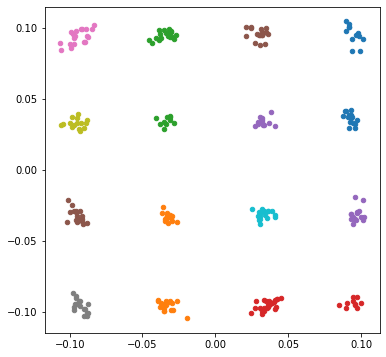

In [62]:
k = 1
x,y,symb = data[0]

# LDBP
z = net.apply(param, x)[k]

# CDC compare
x_cdc1 = L(x[k], 0, -span_length, H0)
h = DBP_h2(-span_length,101)
x_cdc2 = circFilter(h,y0)

# FDBP
x_fdbp0 = fdbp_fiber(y, dz=100)
x_fdbp = wdm_split(x_fdbp0, Nch, sps_single)[chid]

# SDBP
x_sdbp = sdbp_fiber(y0, dz=100)

plt.figure(figsize=(6,6))
show_symb(z[::16],jax.device_get(symb[k,:,0]),s=20)

In [ ]:
path = f'/home/xiaoxinyu/data/0814train_toy/data_power10'
data = pickle.load(open(path, 'rb'))
data = [(x[:,::4,:],y[:,::4,:], symb) for (x,y,symb) in  data]
x,y,symb = data[0]
net = realize(LDBP(length=span_length*span_number, steps=10, nn_mode=False))
tx = optax.adam(learning_rate=0.001)


update_step = construct_update(net, tx)
param = net.init(rd.PRNGKey(123), x)
opt_state = tx.init(param)
param, opt_state = train(update_step, param, opt_state, data,epochs=100)


epoch 0 iter 0: loss 0.0324295 
epoch 0 iter 20: loss 0.00200419 
epoch 0 iter 40: loss 0.00157882 
epoch 0 iter 60: loss 0.00152122 
epoch 0 iter 80: loss 0.00147577 
epoch 1 iter 0: loss 0.00147467 
epoch 1 iter 20: loss 0.00151052 
epoch 1 iter 40: loss 0.00147526 
epoch 1 iter 60: loss 0.0014684 
epoch 1 iter 80: loss 0.00141931 
epoch 2 iter 0: loss 0.00136541 
epoch 2 iter 20: loss 0.00140994 
epoch 2 iter 40: loss 0.00129294 
epoch 2 iter 60: loss 0.00123782 
epoch 2 iter 80: loss 0.00118947 
epoch 3 iter 0: loss 0.00117474 
epoch 3 iter 20: loss 0.00123014 
epoch 3 iter 40: loss 0.0011641 
epoch 3 iter 60: loss 0.00116466 
epoch 3 iter 80: loss 0.00108968 
epoch 4 iter 0: loss 0.00109776 
epoch 4 iter 20: loss 0.00126163 
epoch 4 iter 40: loss 0.00116078 
epoch 4 iter 60: loss 0.00107662 
epoch 4 iter 80: loss 0.00103135 
epoch 5 iter 0: loss 0.00102319 
epoch 5 iter 20: loss 0.00107183 
epoch 5 iter 40: loss 0.00104718 
epoch 5 iter 60: loss 0.00103994 
epoch 5 iter 80: loss 0

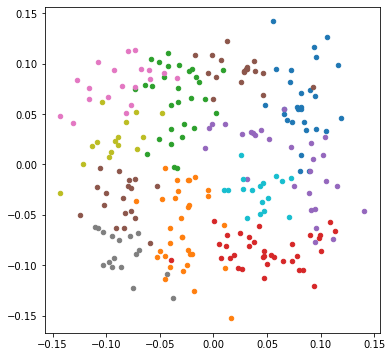

In [ ]:
k = 1
x,y,symb = data[0]
z = net.apply(param, x)[k]
plt.figure(figsize=(6,6))
show_symb(z[0::4],jax.device_get(symb[k,:,0]),s=20)

# Train power = 17

In [16]:
path = f'/home/xiaoxinyu/data/0814train_toy/data_power17'
data = pickle.load(open(path, 'rb'))
x,y,symb = data[0]
net = realize(LDBP(length=span_length*span_number, steps=5, nn_mode=True))
tx = optax.adam(learning_rate=0.001)

update_step = construct_update(net, tx)
param = net.init(rd.PRNGKey(123), x)
opt_state = tx.init(param)
param, opt_state = train(update_step, param, opt_state, data,epochs=10)

/home/xiaoxinyu/.conda/envs/commplax/lib/python3.8/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


epoch 0 iter 0: loss 0.200149 
epoch 0 iter 20: loss 0.173851 
epoch 0 iter 40: loss 0.152631 
epoch 0 iter 60: loss 0.13611 
epoch 0 iter 80: loss 0.122664 
epoch 1 iter 0: loss 0.112087 
epoch 1 iter 20: loss 0.103656 
epoch 1 iter 40: loss 0.0967531 
epoch 1 iter 60: loss 0.0905941 
epoch 1 iter 80: loss 0.0859856 
epoch 2 iter 0: loss 0.0816212 
epoch 2 iter 20: loss 0.077987 
epoch 2 iter 40: loss 0.0753317 
epoch 2 iter 60: loss 0.0725434 
epoch 2 iter 80: loss 0.0703976 
epoch 3 iter 0: loss 0.0683715 
epoch 3 iter 20: loss 0.0666153 
epoch 3 iter 40: loss 0.0653379 
epoch 3 iter 60: loss 0.0641149 
epoch 3 iter 80: loss 0.0630326 
epoch 4 iter 0: loss 0.0618619 
epoch 4 iter 20: loss 0.0609977 
epoch 4 iter 40: loss 0.0602391 
epoch 4 iter 60: loss 0.05962 
epoch 4 iter 80: loss 0.0589962 
epoch 5 iter 0: loss 0.0582341 
epoch 5 iter 20: loss 0.0577889 
epoch 5 iter 40: loss 0.0572795 
epoch 5 iter 60: loss 0.0569162 
epoch 5 iter 80: loss 0.0565388 
epoch 6 iter 0: loss 0.0559

In [19]:
param, opt_state = train(update_step, param, opt_state, data,epochs=200)

epoch 0 iter 0: loss 0.0433479 
epoch 0 iter 20: loss 0.0434164 
epoch 0 iter 40: loss 0.0432657 
epoch 0 iter 60: loss 0.0433011 
epoch 0 iter 80: loss 0.0434154 
epoch 1 iter 0: loss 0.0433325 
epoch 1 iter 20: loss 0.0433996 
epoch 1 iter 40: loss 0.0432519 
epoch 1 iter 60: loss 0.0432883 
epoch 1 iter 80: loss 0.043401 
epoch 2 iter 0: loss 0.0433179 
epoch 2 iter 20: loss 0.0433834 
epoch 2 iter 40: loss 0.0432389 
epoch 2 iter 60: loss 0.0432757 
epoch 2 iter 80: loss 0.0433875 
epoch 3 iter 0: loss 0.0433039 
epoch 3 iter 20: loss 0.0433678 
epoch 3 iter 40: loss 0.0432265 
epoch 3 iter 60: loss 0.0432631 
epoch 3 iter 80: loss 0.0433745 
epoch 4 iter 0: loss 0.0432908 
epoch 4 iter 20: loss 0.0433529 
epoch 4 iter 40: loss 0.0432148 
epoch 4 iter 60: loss 0.0432507 
epoch 4 iter 80: loss 0.043362 
epoch 5 iter 0: loss 0.0432784 
epoch 5 iter 20: loss 0.0433386 
epoch 5 iter 40: loss 0.0432039 
epoch 5 iter 60: loss 0.0432385 
epoch 5 iter 80: loss 0.0433499 
epoch 6 iter 0: lo

In [23]:
z[0::sps].shape

(128, 1)

In [24]:
symb[k,:,0].shape

(256,)

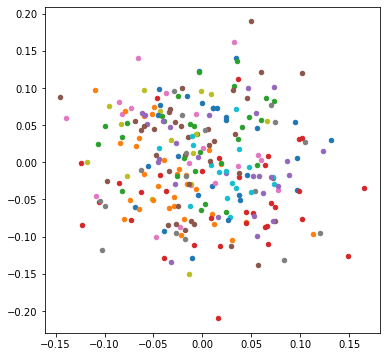

In [27]:
k = 1
x,y,symb = data[0]
z = net.apply(param, x)[k]
plt.figure(figsize=(6,6))
show_symb(z[0::16],jax.device_get(symb[k,:,0]),s=20)

## 6.3 Learn Pertubation

In [ ]:
H_vmap = jax.vmap(DBP_H2, )

class Learn_RP(nn.Module):

    @nn.compact
    def __call__(self,x):
        


# 7.接收机DSP

# **7.Experiments**

## 7.1 SSFM convergence

In [ ]:
dz = [8e3, 4e3, 2e3, 1e3, 5e2, 250, 125, 62.5, 31.25]
sigWDM, symbWDM, param = Tx(rd.PRNGKey(0), 1)
x = sigWDM[:,0]
Eo1,loss1 = test_convergence(x, partial(ssfm1,H=H1, Leff=Leff1), dz, span_length)
Eo2,loss2 = test_convergence(x, partial(ssfm2,H=H1, Leff=Leff1), dz, span_length)
Eo3,loss3 = test_convergence(x, partial(ssfm1,H=H2, Leff=Leff2), dz, span_length)
Eo4,loss4 = test_convergence(x, partial(ssfm2,H=H2, Leff=Leff2), dz, span_length)

Error of two scheme: nomalization or not
distance of two solution: 0.0014550626461955827


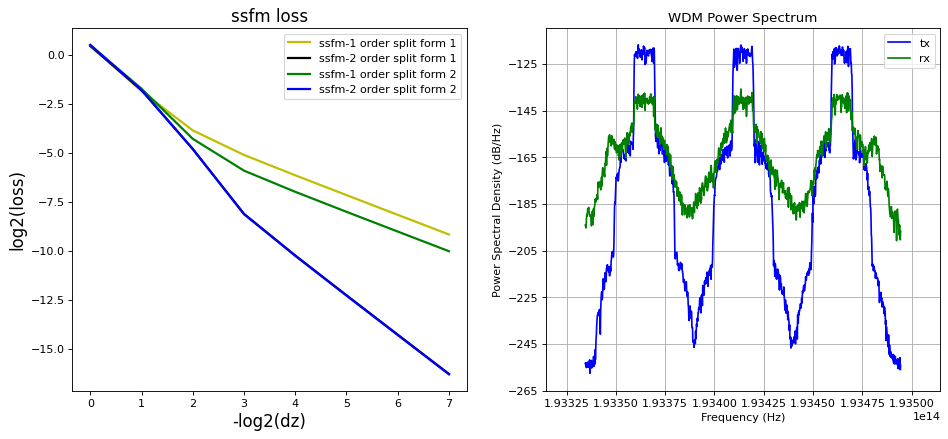

In [37]:

print('Error of two scheme: nomalization or not')
relative_L2(amp1(Eo2[-1],span_length), Eo4[-1])


plt.figure(figsize=(14,6), dpi=80)
plt.subplot(1,2,1)
plt.xlabel('-log2(dz)',size=15)
plt.ylabel('log2(loss)',size=15)
plt.plot(np.log2(loss1),label='ssfm-1 order split form 1', linewidth=2, color='y')
plt.plot(np.log2(loss2),label='ssfm-2 order split form 1', linewidth=2, color='k')
plt.plot(np.log2(loss3),label='ssfm-1 order split form 2', linewidth=2, color='g')
plt.plot(np.log2(loss4),label='ssfm-2 order split form 2', linewidth=2, color='b')
plt.legend()
plt.title('ssfm loss',size=15)


plt.subplot(1,2,2)
plt.psd(x, NFFT=4096//4, Fs=Rs*sps, Fc=fc,sides='twosided',color='b', label='tx')
plt.psd(Eo2[-1], NFFT=4096//4, Fs=Rs*sps, Fc=fc,sides='twosided',color='g', label='rx')
plt.legend()

plt.xlim([param.Fc - (Nch+1)/2*freqspace, param.Fc + (Nch+1)/2*freqspace])
plt.title('WDM Power Spectrum')
plt.xlabel('Frequency (Hz)')

def normalize(x):
    return x/L2(x)
print('distance of two solution:',L2(normalize(Eo1[-1]) - normalize(Eo3[-1])))

## 5.2 WDM-SSFM convergence

Sample rate fa: 1.6e+11, Cut off frequency fc: 7.5e+10, fa > 2fc: True
Transmitter is working..
signal shape: (4096, 3, 1), symb shape: (256, 3, 1)
 Tx_data complete, time cost(s):1.5107674598693848
Error of two scheme: nomalization or not--- 0.0030160066755657356


Text(0.5, 1.0, 'cssfm loss')

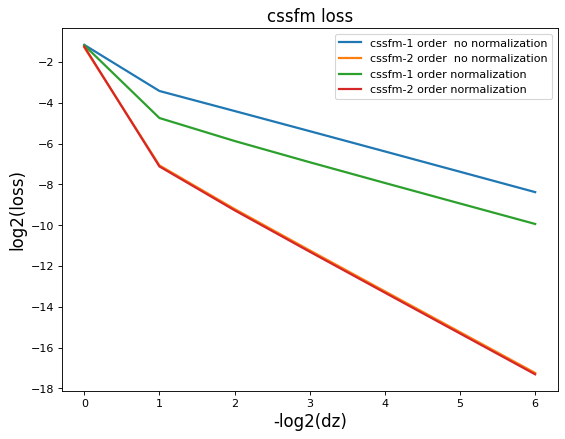

In [65]:
Tx = partial(Tx_data, Nch=Nch, Power=power, SpS=sps, Nbits=4*Nsymb, Rs=Rs, freq_space=freqspace, Nmodes=1, pulse_taps=pulse_taps)
sigWDM, symbWDM, param = Tx(rd.PRNGKey(0), 1, equation='CNLSE')
E = sigWDM[::sps//sps_single,:,0].T
dz = [8e3, 4e3, 2e3, 1e3, 5e2, 250, 125, 62.5]
y1,l1 = test_convergence(E, partial(cssfm1, H=CH1, Leff=CLeff1), dz, span_length)
y2,l2 = test_convergence(E, partial(cssfm2, H=CH1, Leff=CLeff1), dz, span_length)
y3,l3 = test_convergence(E, partial(cssfm1, H=CH2, Leff=CLeff2), dz, span_length)
y4,l4 = test_convergence(E, partial(cssfm2, H=CH2, Leff=CLeff2), dz, span_length)
print('Error of two scheme: nomalization or not---',relative_L2(amp1(y1[-1],span_length), y4[-1]).item())

plt.figure(figsize=(8,6), dpi=80)
plt.xlabel('-log2(dz)',size=15)
plt.ylabel('log2(loss)',size=15)
plt.plot(np.log2(l1),label='cssfm-1 order  no normalization', linewidth=2)
plt.plot(np.log2(l2),label='cssfm-2 order  no normalization', linewidth=2)
plt.plot(np.log2(l3),label='cssfm-1 order normalization', linewidth=2)
plt.plot(np.log2(l4),label='cssfm-2 order normalization', linewidth=2)
plt.legend()
plt.title('cssfm loss',size=15)

## 5.3 FWM noise

Sample rate fa: 1.6e+11, Cut off frequency fc: 7.5e+10, fa > 2fc: True
Transmitter is working..
signal shape: (4096, 1), symb shape: (256, 3, 1)
 Tx_data complete, time cost(s):2.2861270904541016


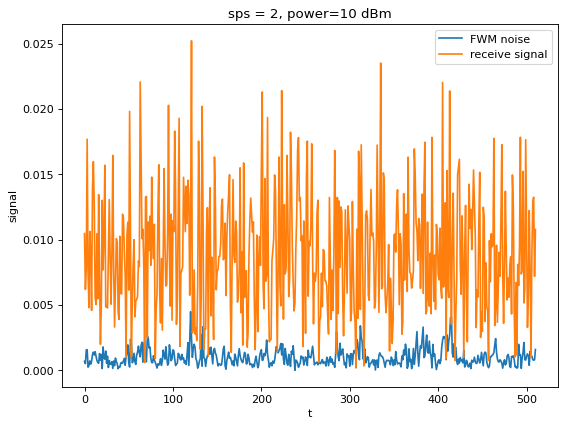

In [ ]:
Tx = partial(Tx_data, Nch=Nch, Power=power, SpS=sps, Nbits=4*Nsymb, Rs=Rs, freq_space=freqspace, Nmodes=1, pulse_taps=pulse_taps)
sigWDM, symbWDM, param = Tx(rd.PRNGKey(0), 1)
x = sigWDM[:,0]

dz = 50
Eo = ssfm2(x,span_length,dz)
ssfm_result = wdm_split(Eo, Nch, sps_single)

Ei = wdm_split(x, Nch, sps_single)
wdm_ssfm_result = cssfm2(Ei,span_length,dz)

chid = Nch//2
s = 0
e = -1
plt.figure(figsize=(8,6),dpi=80)
plt.plot(jnp.abs(wdm_ssfm_result[chid,s:e]-ssfm_result[chid,s:e]), label='FWM noise')
plt.plot(jnp.abs(wdm_ssfm_result[chid,s:e]), label='receive signal')
plt.xlabel('t')
plt.ylabel('signal')
plt.title(f'sps = {sps_single}, power={power} dBm')
plt.legend()

## 5.4 XPM noise

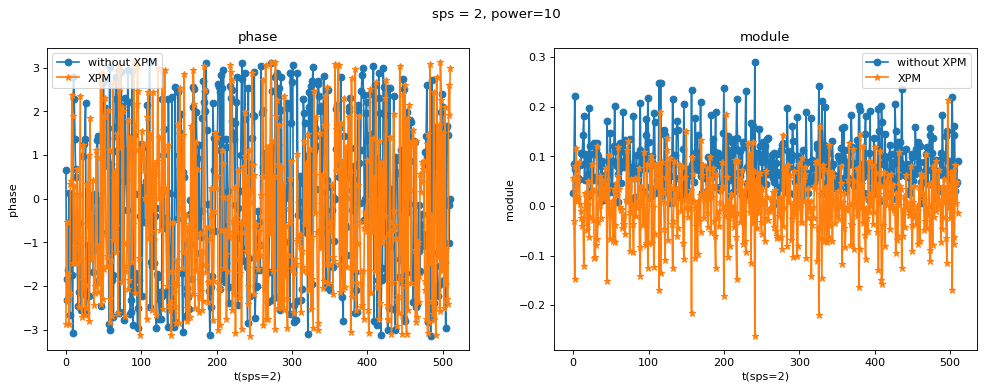

In [ ]:
Tx = partial(Tx_data, Nch=Nch, Power=power, SpS=sps, Nbits=4*Nsymb, Rs=Rs, freq_space=freqspace, Nmodes=1, pulse_taps=pulse_taps)
sigWDM, symbWDM, param = Tx(rd.PRNGKey(0), 1)
x = sigWDM[:,0]

E = wdm_split(x, Nch, sps_single)
mask = jnp.zeros(Nch)
mask = mask.at[chid].set(1)
Es = mask[:,None] * E
span_number = 10
ys = fiber(Es,dz=50,spans=span_number,span_length=span_length, module=partial(cssfm1, H=CH2, Leff=CLeff2))
y  = fiber(E,dz=50,spans=span_number,span_length=span_length, module=partial(cssfm1, H=CH2, Leff=CLeff2))

plt.figure(figsize=(15,5),dpi=80)

plt.suptitle(f'sps = {sps_single}, power={power}')
plt.subplot(1,2,1)
plt.plot(jnp.angle(ys[chid,s:e]),'-o',label='without XPM')
plt.plot(jnp.angle(y[chid,s:e]/ys[chid,s:e]),'-*', label='XPM')
plt.title('phase')
plt.xlabel('t(sps=2)')
plt.ylabel('phase')
plt.legend()

plt.subplot(1,2,2)
plt.plot(jnp.abs(ys[chid,s:e]),'-o',label='without XPM')
plt.plot(jnp.abs(y[chid,s:e]) - jnp.abs(ys[chid,s:e]) ,'-*',label='XPM')
plt.title('module')
plt.xlabel('t(sps=2)')
plt.ylabel('module')
plt.legend()

## 5.5 Manakov convergence

Sample rate fa: 1.6e+11, Cut off frequency fc: 7.5e+10, fa > 2fc: True
Transmitter is working..
signal shape: (4096, 2), symb shape: (256, 3, 2)
 Tx_data complete, time cost(s):1.981250524520874


Text(0.5, 1.0, 'cssfm loss')

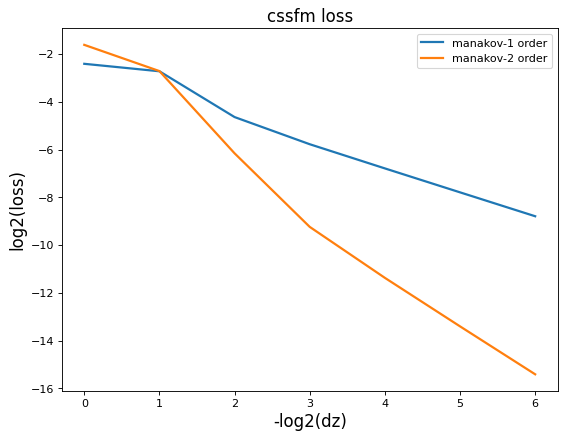

In [ ]:
Tx = partial(Tx_data, Nch=Nch, Power=power, SpS=sps, Nbits=4*Nsymb, Rs=Rs, freq_space=freqspace, Nmodes=2, pulse_taps=pulse_taps)
sigWDM, symbWDM, param = Tx(rd.PRNGKey(0), 1)

dz = [8e3, 4e3, 2e3, 1e3, 5e2, 250, 125, 62.5]
y1,l1 = test_convergence(sigWDM, manakov1, dz, 80e3)
y2,l2 = test_convergence(sigWDM, manakov2, dz, 80e3)

plt.figure(figsize=(8,6), dpi=80)
plt.xlabel('-log2(dz)',size=15)
plt.ylabel('log2(loss)',size=15)
plt.plot(np.log2(l1),label='manakov-1 order', linewidth=2)
plt.plot(np.log2(l2),label='manakov-2 order', linewidth=2)
plt.legend()
plt.title('cssfm loss',size=15)

## 5.6 WDM-Manakov convergence

Sample rate fa: 1.6e+11, Cut off frequency fc: 7.5e+10, fa > 2fc: True
Transmitter is working..
signal shape: (4096, 2), symb shape: (256, 3, 2)
 Tx_data complete, time cost(s):1.8796236515045166


Text(0.5, 1.0, 'wdm-manakov loss')

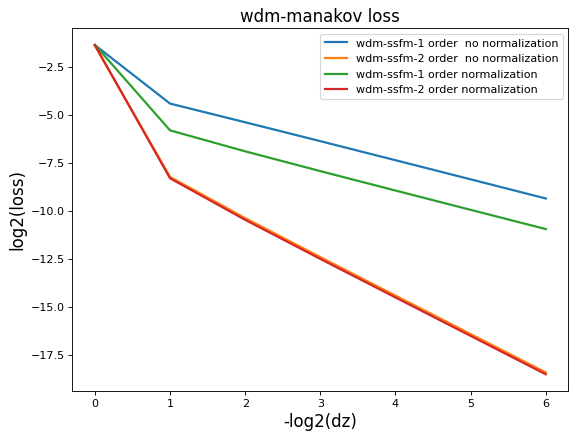

In [ ]:
Tx = partial(Tx_data, Nch=Nch, Power=power, SpS=sps, Nbits=4*Nsymb, Rs=Rs, freq_space=freqspace, Nmodes=2, pulse_taps=pulse_taps)
sigWDM, symbWDM, param = Tx(rd.PRNGKey(0), 1)
x = sigWDM[:,0]

Ed = dual_wdm_split(sigWDM, Nch, sps_single)
dz = [8e3, 4e3, 2e3, 1e3, 5e2, 250, 125, 62.5]
y1,l1 = test_convergence(Ed, partial(cmanakov1, H=CMH1, Leff=CMLeff1), dz, span_length)
y2,l2 = test_convergence(Ed, partial(cmanakov2, H=CMH1, Leff=CMLeff1), dz, span_length)
y3,l3 = test_convergence(Ed, partial(cmanakov1, H=CMH2, Leff=CMLeff2), dz, span_length)
y4,l4 = test_convergence(Ed, partial(cmanakov2, H=CMH2, Leff=CMLeff2), dz, span_length)

plt.figure(figsize=(8,6), dpi=80)
plt.xlabel('-log2(dz)',size=15)
plt.ylabel('log2(loss)',size=15)
plt.plot(np.log2(l1),label='wdm-ssfm-1 order  no normalization', linewidth=2)
plt.plot(np.log2(l2),label='wdm-ssfm-2 order  no normalization', linewidth=2)
plt.plot(np.log2(l3),label='wdm-ssfm-1 order normalization', linewidth=2)
plt.plot(np.log2(l4),label='wdm-ssfm-2 order normalization', linewidth=2)
plt.legend()
plt.title('wdm-manakov loss',size=15)

## 5.7 Nonlinear polarization cross talk

Sample rate fa: 1.6e+11, Cut off frequency fc: 7.5e+10, fa > 2fc: True
Transmitter is working..
signal shape: (4096, 2), symb shape: (256, 3, 2)
 Tx_data complete, time cost(s):1.8216190338134766


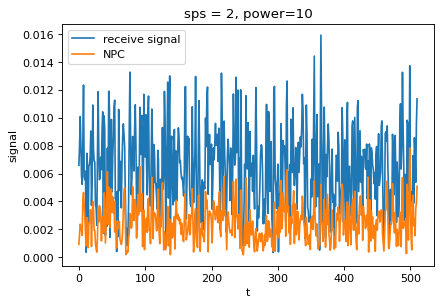

In [ ]:
# WDM-Manakov
Tx = partial(Tx_data, Nch=Nch, Power=power, SpS=sps, Nbits=4*Nsymb, Rs=Rs, freq_space=freqspace, Nmodes=2, pulse_taps=pulse_taps)
sigWDM, symbWDM, param = Tx(rd.PRNGKey(0), 1)
x = sigWDM[:,0]

Ed = dual_wdm_split(sigWDM, Nch, sps_single)   # 分通道信号  [Nch, Nfft, Nmodes]
y0 = cmanakov1(Ed, span_length, 100)

# Manakov
y_wdm = manakov1(sigWDM, span_length, 100)
y_true = dual_wdm_split(y_wdm,Nch,sps_single)

s = 0
e = -1

plt.figure(figsize=(6,4),dpi=80)
plt.plot(jnp.abs(y_true[chid,s:e,0]), label='receive signal')
plt.plot(jnp.abs(y0[chid,s:e,0] - y_true[chid,s:e,0]), label='NPC')
plt.xlabel('t')
plt.ylabel('signal')
plt.title(f'sps = {sps_single}, power={power}')
plt.legend()

## 5.8 pertubation convergence

Sample rate fa: 3.2e+11, Cut off frequency fc: 7.5e+10, fa > 2fc: True
Transmitter is working..
signal shape: (32000, 1), symb shape: (1000, 3, 1)
 Tx_data complete, time cost(s):2.7135674953460693


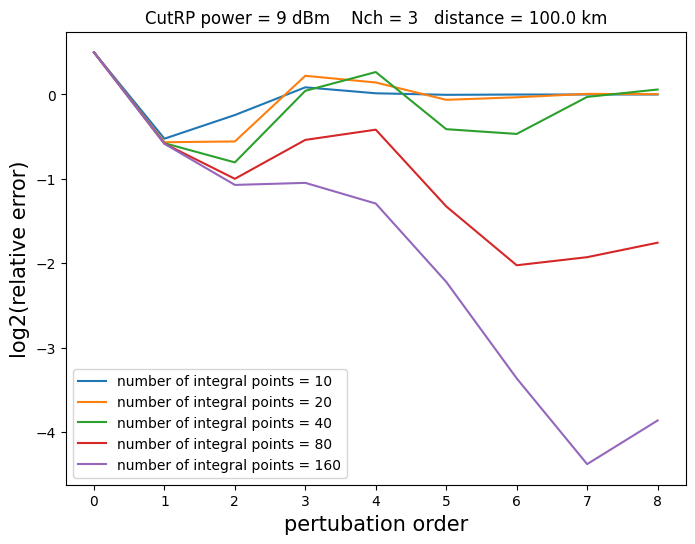

In [96]:
power = 9
Tx = partial(Tx_data, Nch=3, Power=power, SpS=sps, Nbits=4*Nsymb, Rs=Rs, freq_space=freqspace, Nmodes=1, pulse_taps=pulse_taps)
sigWDM, symbWDM, param = Tx(rd.PRNGKey(0), 1)
x = sigWDM[:,0]

integral_points = 10
# psi,v_cutlp = CutLP(x, 80e3, 4, integral_points)
# cutu,v_cutrp = CutRP(x, 80e3, 8, integral_points)   
# v_lp = LP_solver(x, 80e3, 8, integral_points)
points = [10,20,40,80,160]
v_rp = {}
l = {}
for p in points:
    v = CutRP(x, span_length, 8, integral_points=p)[1]
    # v = RP_solver(x, span_length, 8, integral_points=p)
    v_rp[f'number of integral points = {p}'] = v
    
v_true = ssfm2(x, span_length,dz=100,H=H2,Leff=Leff2)
for p,v in v_rp.items():
    l[p] = []
    for i in range(9):
        l[p].append(relative_L2(v[i][-1], v_true))


plt.figure(figsize=(8,6),dpi=100)
plt.xlabel('pertubation order', size=15)
plt.ylabel('log2(relative error)',size=15)
plt.title(f'CutRP power = {power} dBm    Nch = {Nch}   distance = {span_length/1e3} km')
for k,lc in l.items():
    plt.plot(np.log2(lc), label=k)
plt.legend()


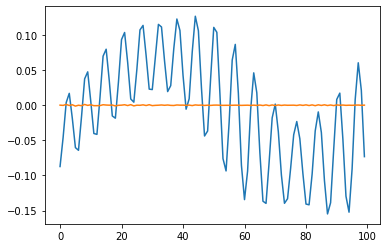

In [78]:
y = v_rp['number of integral points = 160'][-1][-1]
plt.plot(y[0:100].real)
plt.plot(v_true[0:100].real - y[0:100].real)

## 5.9 LP fail convergence ???

In [ ]:
u,v = CutRP(x,80e3 ,4, 20)
p1 = save_divide(u[1], u[0], 1)
p2 = save_divide(u[2], u[0], 2) - 1/2*p1**2
p3 = save_divide(u[3], u[0], 3) - p1*p2 - 1/6*p1**3
p4 = save_divide(u[4], u[0], 4) - p1*p3 - 1/2*p2**2 - 1/2*p1**2*p2 - 1/24*p1**4

psi = [p1,p2,p3,p4]
v = []
v.append(u[0])
for i in range(1,4+1):
    v.append(v[-1]*jnp.exp(gamma**i*psi[i-1])) 

up = []
for i in range(5):
    up.append(u[i][-1][442].item())

p1 = up[1]/up[0]
p2 = up[2]/up[0] - 1/2*p1**2
p3 = up[3]/up[0]- p1*p2 - 1/6*p1**3
p4 = up[4]/up[0] - p1*p3 - 1/2*p2**2 - 1/2*p1**2*p2 - 1/24*p1**4

## CDC

In [ ]:
u,v = CutRP(x,80e3 ,4, 10)

/home/xiaoxinyu/.conda/envs/commplax/lib/python3.8/site-packages/jax/_src/device_array.py:264: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._value, dtype=dtype)
/home/xiaoxinyu/.conda/envs/commplax/lib/python3.8/site-packages/jax/_src/device_array.py:264: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._value, dtype=dtype)


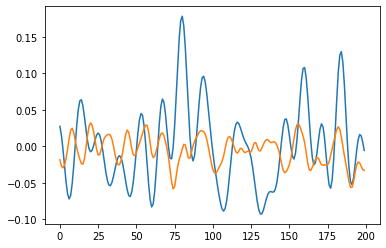

In [ ]:
plt.plot(u[0][-1,:][10000:10200])
plt.plot(u[1][-1,:][10000:10200]*gamma)

# 6.卷积转化

In [ ]:
from optical_flax.operator import circFilter
net = nn.Conv(features=1,kernel_size=(3,),strides=(1,),padding='CIRCULAR')
x = rd.normal(rd.PRNGKey(0),(10,1))
y,p = net.init_with_output(rd.PRNGKey(0), x)
x = jnp.squeeze(x)
h = jnp.squeeze(p['params']['kernel'])
circFilter(jnp.flip(h),x) - jnp.squeeze(y)

DeviceArray([-1.59971695e-07,  1.92412726e-08,  2.26221607e-08,
             -8.52863424e-09,  6.80817607e-08, -1.17440908e-07,
              1.21901792e-07,  1.19220423e-07, -5.84434207e-08,
             -6.11624786e-08], dtype=float64)

In [ ]:
from optical_flax.operator import circFilter
net = nn.Conv(features=2,kernel_size=(3,),strides=(1,),padding='CIRCULAR')
x = rd.normal(rd.PRNGKey(0),(10,5))
y,p = net.init_with_output(rd.PRNGKey(0), x)
p['params']['kernel'].shape   # [kernel_size, Ci, Co]

(3, 5, 2)

# 7.色散卷积算子的实现

compare two linear operator: 4.1107638761563226e-05


Text(0, 0.5, 'h0')

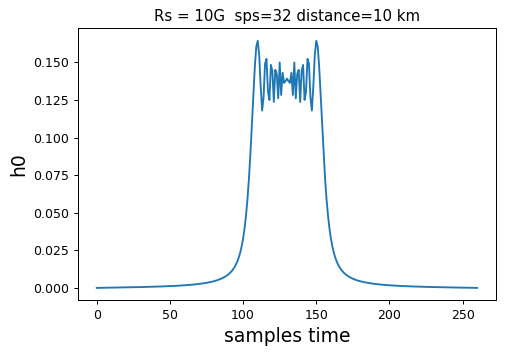

In [103]:
test = rd.normal(rd.PRNGKey(0),(160000,), dtype='complex')


def DBP_H2(dz, Nfft):
    '''
    DBP split form 1: normalization
    kernel: frequency domain
    '''
    omega = 2*np.pi * Fs_single * fftfreq(Nfft)*10
    return jnp.exp(-1j * (beta2/2) * (omega**2) * dz)

def DBP_h2(dz, dtaps):
    '''
    DBP split form 1: normalization
    kernel: time domain
    '''
    return fftshift(ifft(DBP_H2(dz, dtaps)))


def MSE(x,y):
    return jnp.mean(jnp.abs(x-y)**2)

h0 = DBP_h2(-10e3,261)
y1 = ifft(fft(test)*DBP_H2(-10e3, test.shape[0]))
y2 = circFilter(h0, test)
print('compare two linear operator:',MSE(y1,y2))

plt.figure(figsize=(6,4),dpi=90)
plt.plot(jnp.abs(h0))
plt.title(f'Rs = {10}G  sps={sps} distance={10} km')
plt.xlabel('samples time',size=15)
plt.ylabel('h0',size=15)

In [ ]:
def disp_init(key, xi, dtaps):
    k = jax.vmap(DBP_h2,in_axes=(0,None),out_axes=-1)(xi,dtaps)
    return k[:,None,:]  # [dtaps,1,Co]


In [ ]:
disp_init('key',jnp.arange(10),261).shape

(261, 1, 10)